In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

Loading of the dataset and table of the attributes where y is Outcome and X all the other attributes

In [11]:
df = pd.read_csv("data/diabetes.csv")

X = df.drop(columns=["Outcome"])
y = df["Outcome"]

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


Table for how many 0s in each attribute that shouldn't have 0s

In [14]:
# columns where 0 == missing value

zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction"]

zero_counts = (X[zero_cols] == 0).sum()

for col, cnt in zero_counts.items():
    print(f"{col}: {cnt} zeros")

Glucose: 5 zeros
BloodPressure: 35 zeros
SkinThickness: 227 zeros
Insulin: 374 zeros
BMI: 11 zeros
DiabetesPedigreeFunction: 0 zeros


In [16]:
zero_cols = [c for c in zero_cols if c in X.columns]

# 2) rows with any missing value:
#    - NaN anywhere in X
#    - OR a zero in any of zero_cols
to_drop_mask = X.isna().any(axis=1) | X[zero_cols].eq(0).any(axis=1)

rows_to_remove = int(to_drop_mask.sum())
rows_remaining = int(len(X) - rows_to_remove)

print("\nRows to remove (treating 0 as missing in zero_cols):", rows_to_remove)
print("Rows remaining:", rows_remaining)


Rows to remove (treating 0 as missing in zero_cols): 376
Rows remaining: 392


More information about each attribute

In [5]:
# use X if you've already split; otherwise fall back to df
data = X if 'X' in globals() else df

cols = ["Pregnancies","Glucose","BloodPressure","SkinThickness",
        "Insulin","BMI","DiabetesPedigreeFunction","Age"]

summary = (
    data[cols]
    .agg(['count','mean','std','median','min','max'])
    .T.rename(columns={
        'count':'N','mean':'Mean','std':'SD','median':'Median','min':'Min','max':'Max'
    })
)

# formatting: N as int, others to 2 decimals
summary['N'] = summary['N'].astype(int)
summary[['Mean','SD','Median','Min','Max']] = summary[['Mean','SD','Median','Min','Max']].round(2)

# show with the attribute names as a column (like your screenshot)
summary = summary.reset_index().rename(columns={'index':'Attribute'})
print(summary)

                  Attribute    N    Mean      SD  Median    Min     Max
0               Pregnancies  768    3.85    3.37    3.00   0.00   17.00
1                   Glucose  768  120.89   31.97  117.00   0.00  199.00
2             BloodPressure  768   69.11   19.36   72.00   0.00  122.00
3             SkinThickness  768   20.54   15.95   23.00   0.00   99.00
4                   Insulin  768   79.80  115.24   30.50   0.00  846.00
5                       BMI  768   31.99    7.88   32.00   0.00   67.10
6  DiabetesPedigreeFunction  768    0.47    0.33    0.37   0.08    2.42
7                       Age  768   33.24   11.76   29.00  21.00   81.00


Histograms of X attributes

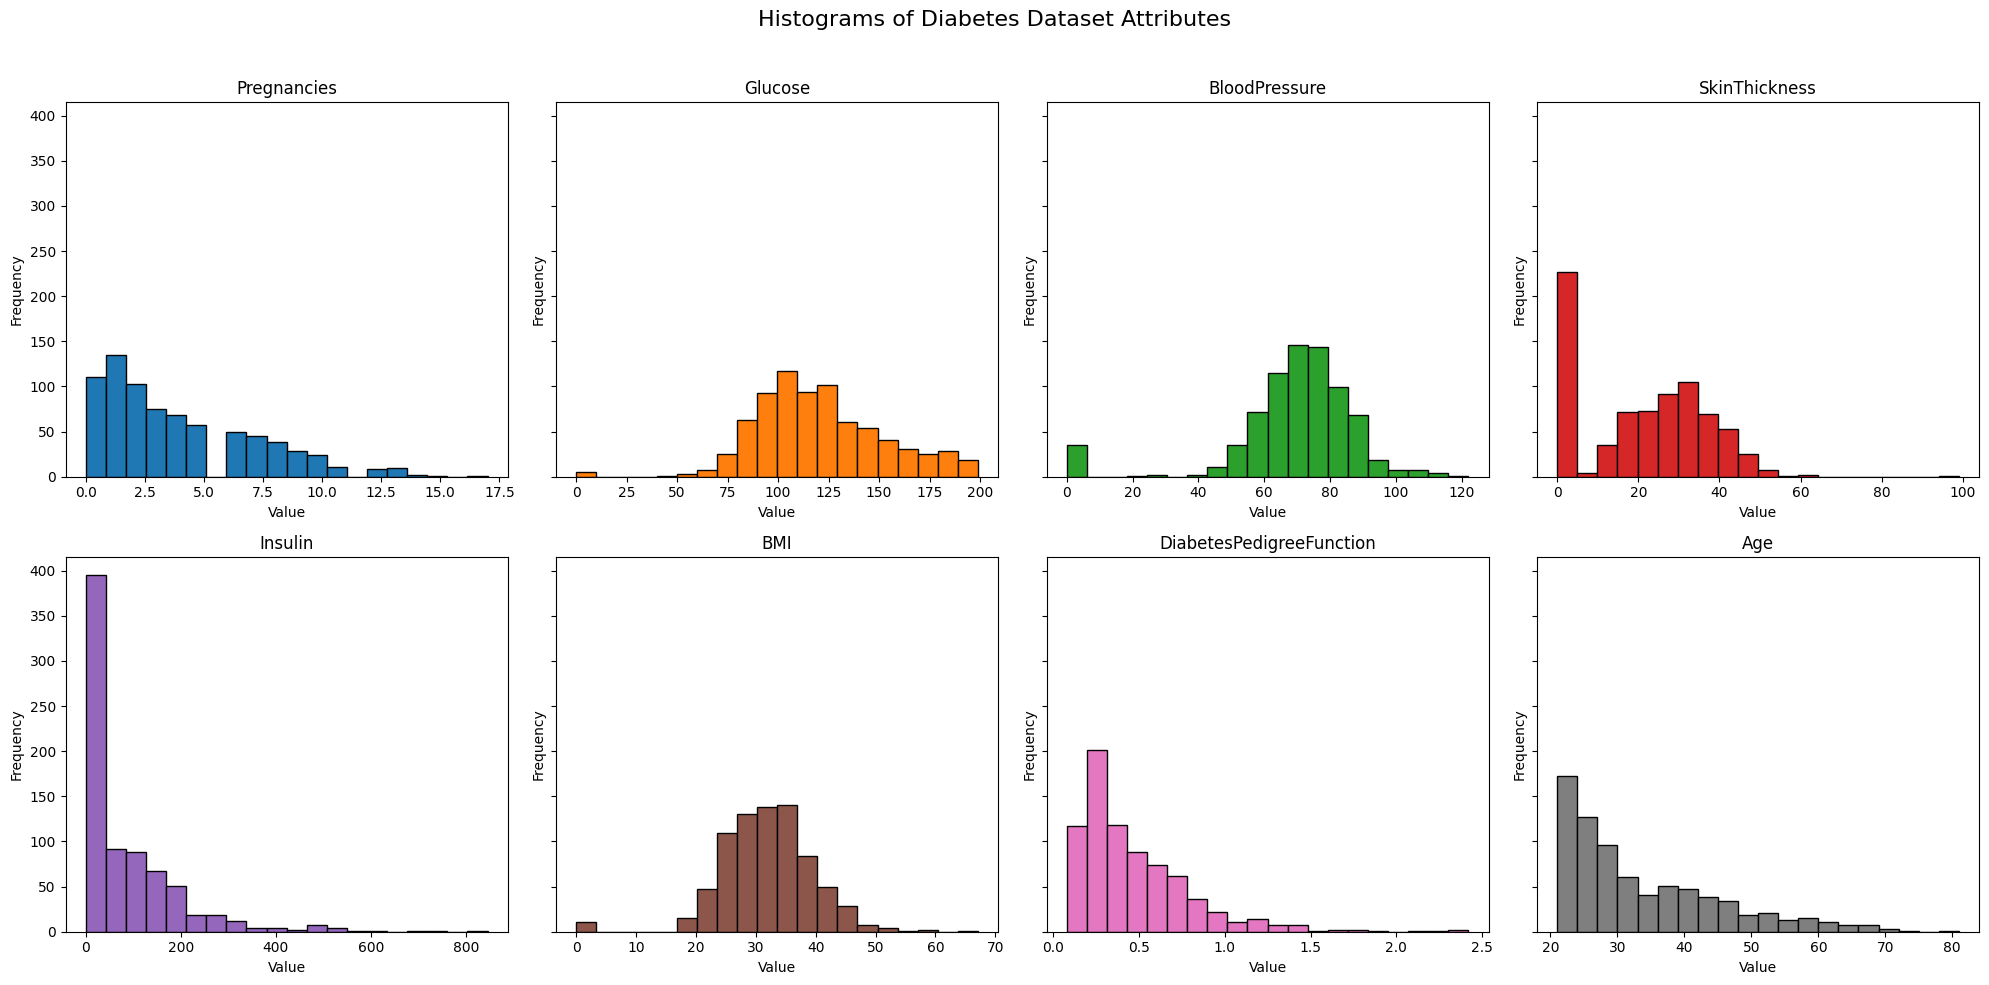

In [3]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
fig.suptitle("Histograms of Diabetes Dataset Attributes", fontsize=16)

axs = axs.flatten()  # flatten 2x4 grid into 1D for easy iteration

for j in range(8):  # loop over your 8 columns
    axs[j].hist(X.iloc[:, j], color=f"C{j}", bins=20, edgecolor='black')
    axs[j].set_title(X.columns[j])
    axs[j].set_xlabel("Value")
    axs[j].set_ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

Boxplots of X attributes

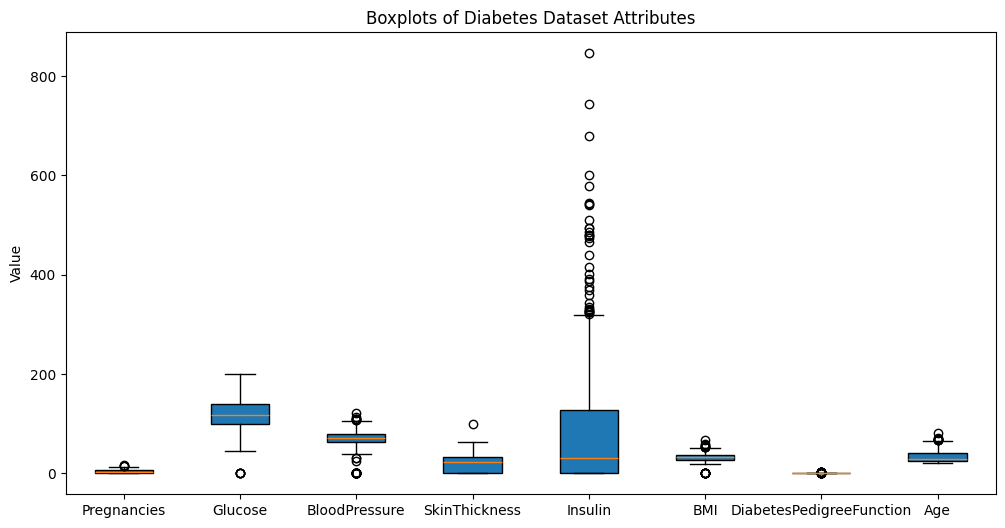

In [7]:
fig = plt.figure(figsize=(12, 6))
plt.title("Boxplots of Diabetes Dataset Attributes")
plt.boxplot([X[col] for col in X.columns], 
            vert=True, patch_artist=True, tick_labels=X.columns)
plt.ylabel("Value")
plt.show()

Scatter matrix of each of the 8 X attributes compared with each other and difference between blue and orange points defining the Outcome

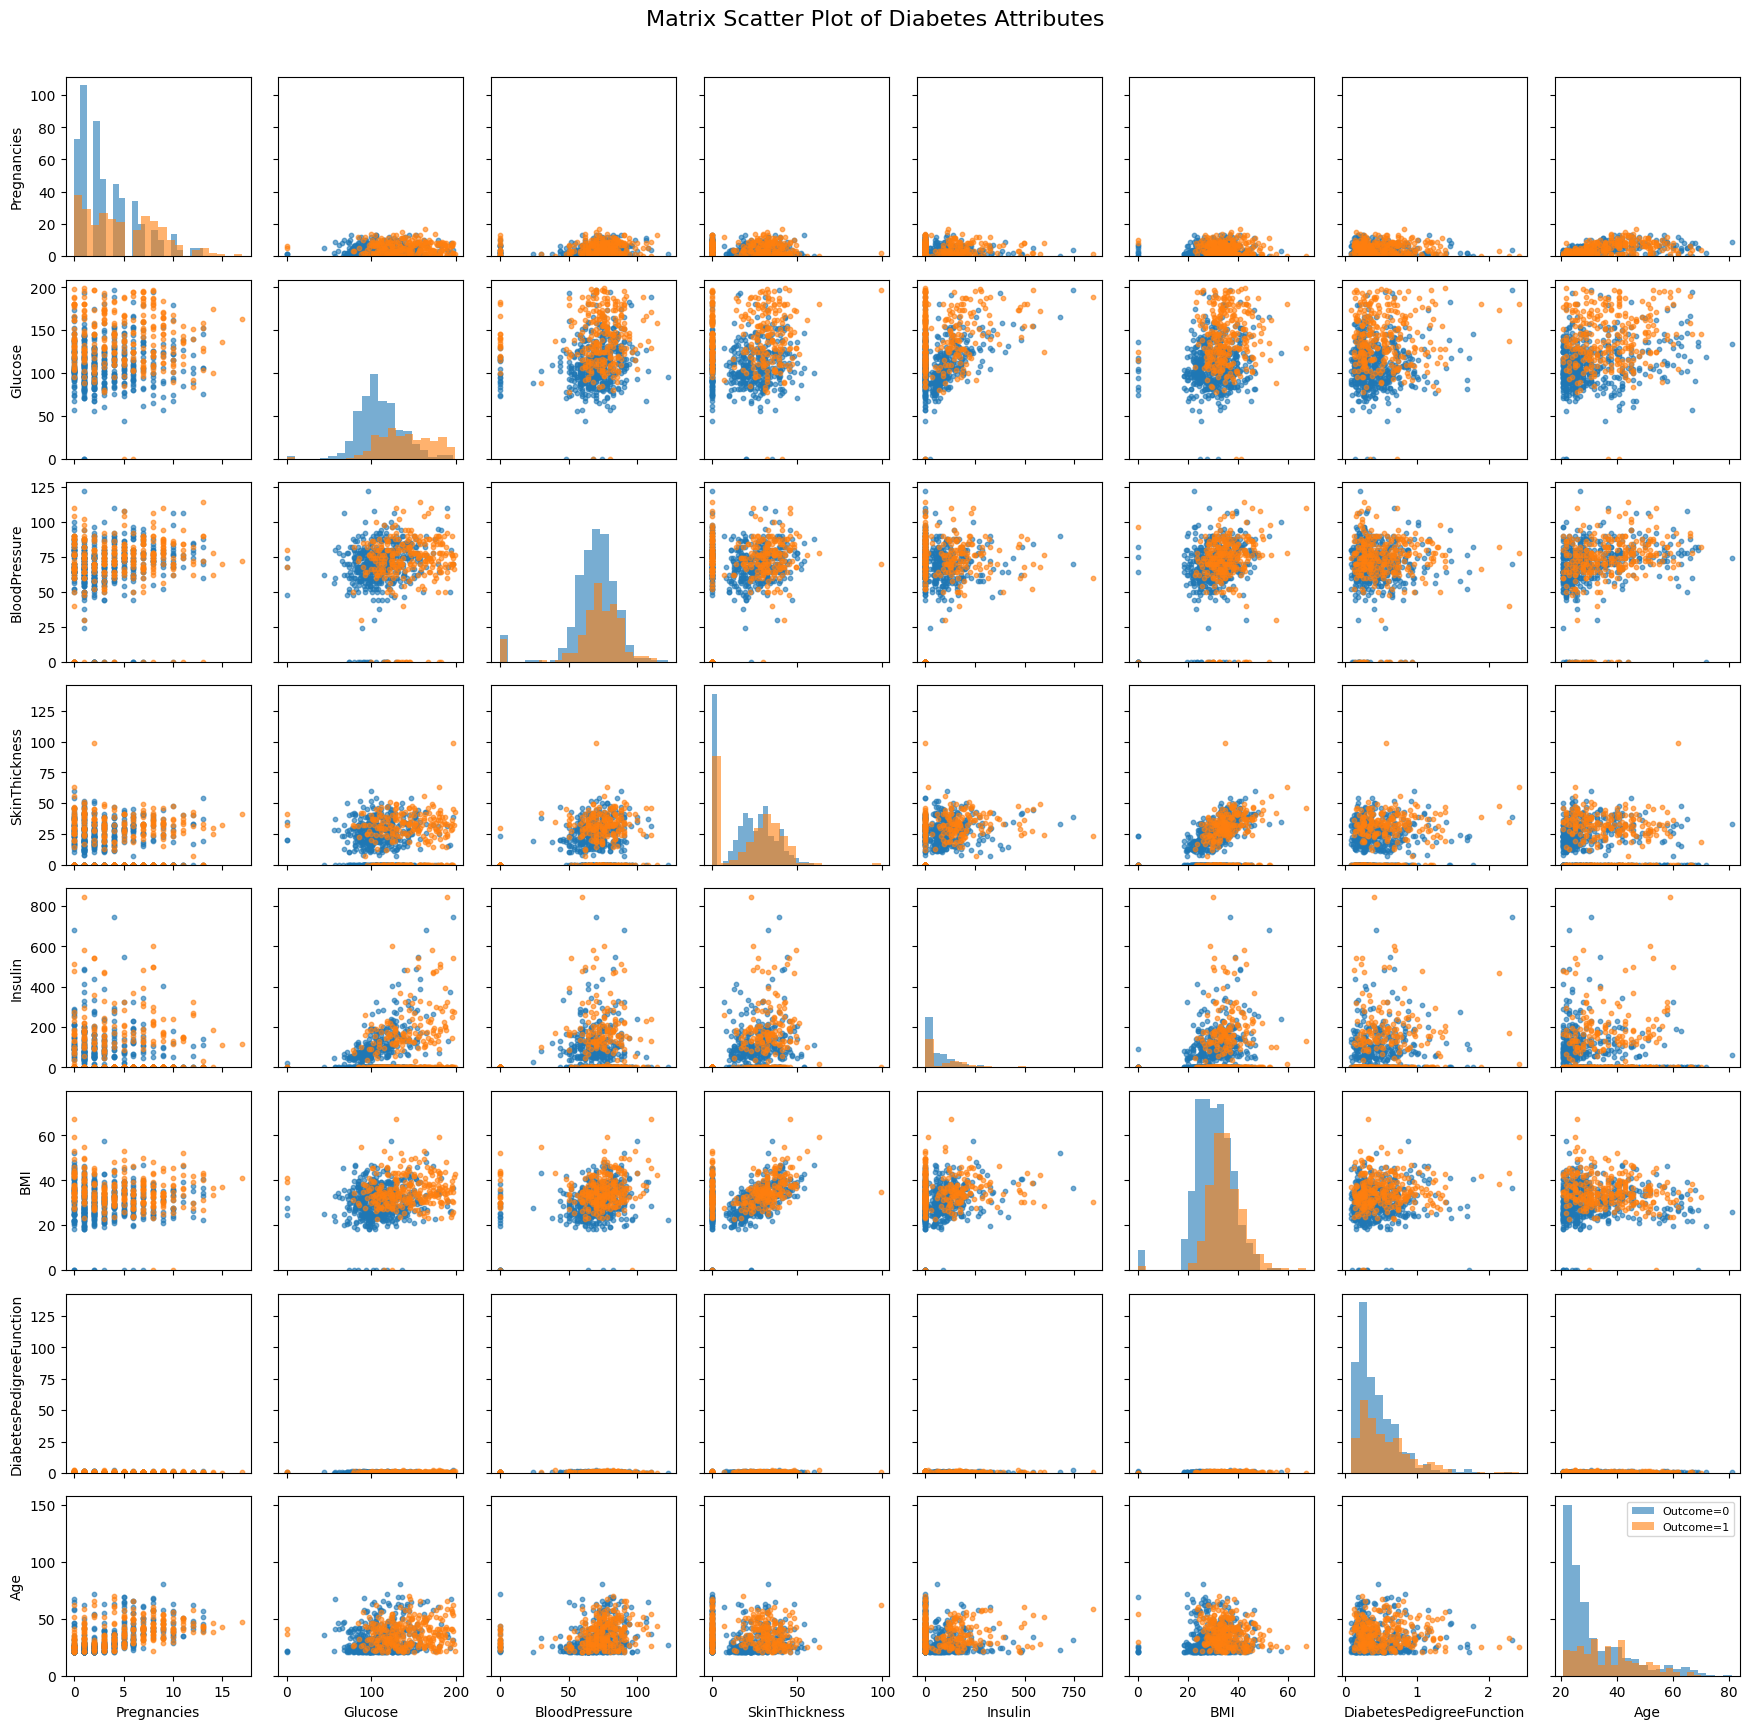

In [21]:
# X = your 8-feature DataFrame
# y = your Outcome Series (0/1)
df_plot = pd.concat([X, y.rename("Outcome")], axis=1)

features = X.columns.tolist()
n = len(features)  # should be 8

fig, axs = plt.subplots(n, n, figsize=(2.2*n, 2.2*n), sharex='col', sharey='row')
fig.suptitle("Matrix Scatter Plot of Diabetes Attributes", fontsize=16)

# Ensure consistent class order
classes = sorted(df_plot["Outcome"].unique())

for i in range(n):
    for j in range(n):
        ax = axs[i, j]
        if i == j:
            # Diagonal: per-class histograms
            for cls in classes:
                subset = df_plot[df_plot["Outcome"] == cls][features[j]]
                ax.hist(subset.dropna(), bins=20, alpha=0.6, label=f"Outcome={cls}")
        else:
            # Off-diagonals: per-class scatter
            for cls in classes:
                subset = df_plot[df_plot["Outcome"] == cls]
                ax.scatter(
                    x=subset[features[j]],
                    y=subset[features[i]],
                    s=10, alpha=0.6, label=f"Outcome={cls}"
                )

        # Only label first column (y labels) and last row (x labels)
        if j == 0:
            ax.set_ylabel(features[i])
        else:
            ax.set_ylabel("")
        if i == n - 1:
            ax.set_xlabel(features[j])
        else:
            ax.set_xlabel("")

# Legend only on the bottom-right subplot
handles, labels = axs[-1, -1].get_legend_handles_labels()
axs[-1, -1].legend(handles, labels, loc='upper right', fontsize=8, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave room for suptitle
plt.show()

0s to NAN and substitution of Nan with the median

In [ ]:
#0s to nan
X[zero_cols] = X[zero_cols].replace(0, np.nan)

# Median substitution
imp = SimpleImputer(strategy="median")
X[zero_cols] = imp.fit_transform(X[zero_cols])

Standardize

In [ ]:
#Standardize
scaler = StandardScaler()
X.loc[:, :] = scaler.fit_transform(X)